In [64]:
#importing dependencies

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import _pickle as cpickle #to store model histories in a file
import os
import imageio
from PIL import Image


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots"

In [65]:
#specifying parameters
image_size = 64
G_input_dim = 100
G_output_dim = 3
D_input_dim = 3
D_output_dim = 1
num_filters = [1024, 512, 256, 128]

learning_rate = 0.0002
betas = (0.5, 0.999)
batch_size = 128
num_epochs = 20

data_dir = './Train_data'
save_dir = './DCGAN_results/'

In [66]:
print(os.getcwd())

/Users/ayushgupta/Desktop/CS231N Project/Project work


In [67]:
#loading data

transform = transforms.Compose([transforms.Scale(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(214.0466981, 206.55220904, 203.99178198), 
                                                     std=(54.34939265, 55.62690195, 58.85794001))])

df_data = dsets.ImageFolder(data_dir, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset=df_data,
                                          batch_size=batch_size,
                                          shuffle=True)


## Helper Functions

In [68]:
# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [69]:
# Plot losses
def plot_loss(d_losses, g_losses, num_epoch, save=False, save_dir='./DCGAN_results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'DCGAN_losses_epoch_{:d}'.format(num_epoch + 1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


def plot_result(generator, noise, num_epoch, save=False, save_dir='./DCGAN_results/', show=False, fig_size=(5, 5)):
    generator.eval()

    gen_image = generator(noise)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = (((img - img.min()) * 255) / (img.max() - img.min())).cpu().data.numpy().transpose(1, 2, 0).astype(np.uint8)
        # ax.imshow(img.cpu().data.view(image_size, image_size, 3).numpy(), cmap=None, aspect='equal')
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch+1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'DCGAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

## Generator Model

In [70]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_filters, output_dim):
        super(Generator, self).__init__()

        # Hidden layers
        self.hidden_layer = nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                deconv = nn.ConvTranspose2d(input_dim, num_filters[i], kernel_size=4, stride=1, padding=0)
            else:
                deconv = nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            deconv_name = 'deconv' + str(i + 1)
            self.hidden_layer.add_module(deconv_name, deconv)

            # Initializer
            nn.init.normal_(deconv.weight, mean=0.0, std=0.02)
            nn.init.constant_(deconv.bias, 0.0)

            # Batch normalization
            bn_name = 'bn' + str(i + 1)
            self.hidden_layer.add_module(bn_name, nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, nn.ReLU())

        # Output layer
        self.output_layer = nn.Sequential()
        # Deconvolutional layer
        out = nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        nn.init.normal_(out.weight, mean=0.0, std=0.02)
        nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', nn.Tanh())

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


## Discriminator Model

In [71]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_filters, output_dim):
        super(Discriminator, self).__init__()

        # Hidden layers
        self.hidden_layer = nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                conv = nn.Conv2d(input_dim, num_filters[i], kernel_size=4, stride=2, padding=1)
            else:
                conv = nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

            conv_name = 'conv' + str(i + 1)
            self.hidden_layer.add_module(conv_name, conv)

            # Initializer
            nn.init.normal_(conv.weight, mean=0.0, std=0.02)
            nn.init.constant_(conv.bias, 0.0)

            # Batch normalization
            if i != 0:
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, nn.BatchNorm2d(num_filters[i]))

            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = nn.Sequential()
        # Convolutional layer
        out = nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        nn.init.normal_(out.weight, mean=0.0, std=0.02)
        nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', nn.Sigmoid())

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out

## Training

/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Step [1/251], D_loss: 1.9517, G_loss: 4.6475
Epoch [1/20], Step [2/251], D_loss: 1.1151, G_loss: 6.3592
Epoch [1/20], Step [3/251], D_loss: 0.2892, G_loss: 7.6200
Epoch [1/20], Step [4/251], D_loss: 0.0896, G_loss: 6.8473
Epoch [1/20], Step [5/251], D_loss: 0.2092, G_loss: 7.6350
Epoch [1/20], Step [6/251], D_loss: 0.1228, G_loss: 8.2361
Epoch [1/20], Step [7/251], D_loss: 0.0853, G_loss: 8.3066
Epoch [1/20], Step [8/251], D_loss: 0.0837, G_loss: 8.4383
Epoch [1/20], Step [9/251], D_loss: 0.0966, G_loss: 9.5572
Epoch [1/20], Step [10/251], D_loss: 0.0363, G_loss: 9.0032
Epoch [1/20], Step [11/251], D_loss: 0.0799, G_loss: 10.1213


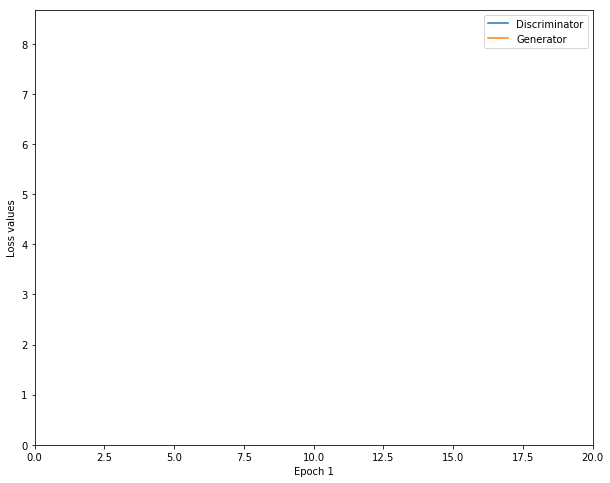

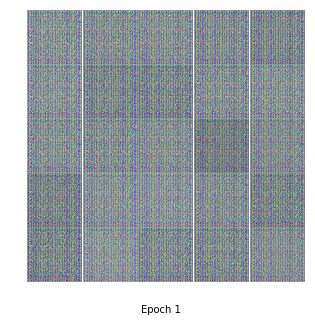

Epoch [2/20], Step [1/251], D_loss: 0.0236, G_loss: 9.2988


KeyboardInterrupt: 

In [72]:
# Models
G = Generator(G_input_dim, num_filters, G_output_dim)
D = Discriminator(D_input_dim, num_filters[::-1], D_output_dim)
# G.cuda()
# D.cuda()

# Loss function
criterion = nn.BCELoss()
#criterion = F.binary_cross_entropy

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

# Training GAN
D_avg_losses = []
G_avg_losses = []

# Fixed noise for test
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, G_input_dim).view(-1, G_input_dim, 1, 1)

for epoch in range(num_epochs):
    D_losses = []
    G_losses = []

    # if epoch == 5:
    #     G_optimizer.param_groups[0]['lr'] /= 10
    #     D_optimizer.param_groups[0]['lr'] /= 10

    # minibatch training
    for i, (images, _) in enumerate(data_loader):

        # image data
        mini_batch = images.size()[0]
        #x_ = Variable(images.cuda())
        x_ = images
        x_.requires_grad = True
        
        # labels
        #y_real_ = Variable(torch.ones(mini_batch).cuda())
        #y_fake_ = Variable(torch.zeros(mini_batch).cuda())
        y_real_ = torch.ones(mini_batch, requires_grad = False)
        y_fake_ = torch.zeros(mini_batch, requires_grad = False)

        # Train discriminator with real data
        D_real_decision = D(x_).squeeze()
        # print(D_real_decision, y_real_)
        D_real_loss = criterion(D_real_decision, y_real_)

        # Train discriminator with fake data
        z_ = torch.randn(mini_batch, G_input_dim, requires_grad = True)
        z_ = z_.view(-1, G_input_dim, 1, 1)
        
        gen_image = G(z_)

        D_fake_decision = D(gen_image).squeeze()
        D_fake_loss = criterion(D_fake_decision, y_fake_)

        # Back propagation
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        z_ = torch.randn(mini_batch, G_input_dim, requires_grad = True)
        z_ = z_.view(-1, G_input_dim, 1, 1)
        gen_image = G(z_)

        D_fake_decision = D(gen_image).squeeze()
        G_loss = criterion(D_fake_decision, y_real_)

        # Back propagation
        D.zero_grad()
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.data[0])
        G_losses.append(G_loss.data[0])

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, num_epochs, i+1, len(data_loader), D_loss.data[0], G_loss.data[0]))
        
#         if (i == 10):
#             break

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    plot_loss(D_avg_losses, G_avg_losses, epoch, save=True, show=True)

    # Show result for fixed noise
    plot_result(G, fixed_noise, epoch, save=True, fig_size=(5, 5), show = True)
